# Marketing A/B Testing Project

## Objective

In this project, we aim to evaluate the effectiveness of a marketing campaign by analyzing an A/B testing dataset. A/B testing is a common practice where two groups—an experimental group and a control group—are exposed to different stimuli (in this case, ads vs. public service announcements) to determine the impact of the ads on conversion rates.

The two key objectives we want to answer are:
1. **Campaign Success**: Was the campaign successful overall in terms of conversions?
2. **Ad Impact**: How much of the campaign's success can be attributed to the ads specifically?

To answer these questions, we will analyze user behavior from the dataset, compare the results between the groups, and use statistical methods to determine if the differences between the groups are significant.

## Data Overview

The dataset contains information about:
- **User ID**: Unique identifiers for each user.
- **Test Group**: Whether the user saw the advertisement (ad) or a public service announcement (psa).
- **Converted**: Indicates whether the user purchased the product (True/False).
- **Total Ads**: The total number of ads the person saw.
- **Most Ads Day**: The day when the person saw the most ads.
- **Most Ads Hour**: The hour of the day when the person saw the most ads.

## Approach

We will follow a systematic approach to analyze the data and answer the key objectives:

1. **Data Cleaning**: Ensure the data is clean and ready for analysis by handling missing values, duplicate entries, and other inconsistencies.
2. **Exploratory Data Analysis (EDA)**: Perform EDA to understand the data distribution, find trends, and gather insights regarding user behavior and ad exposure.
3. **Conversion Rate Calculation**: Calculate the conversion rates for each group and compare their performance over different time frames (day, hour, etc.).
4. **Power Analysis**: Conduct power analysis to determine the sample size required to detect a meaningful effect, ensuring that the results are statistically valid.
5. **A/B Testing**: Perform A/B testing using both proportion Z-tests and Chi-square tests to compare the conversion rates of the ad group vs. the PSA group and assess the statistical significance.
6. **Time Analysis**: Investigate the relationship between the time slots (days and hours) and the conversion rates to find the optimal times for displaying ads.
7. **Conclusion & Insights**: Summarize the findings and determine whether the campaign was successful, how well the ads performed, and make strategic recommendations based on the results.

By following this approach, we will provide a clear and thorough understanding of the campaign's effectiveness and offer actionable insights for future marketing efforts.


#### Importing required modules.

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
data = pd.read_csv("marketing_AB.csv")

### Data Preprocessing

In [3]:
data.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [4]:
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

user id          588101
test group            2
converted             2
total ads           807
most ads day          7
most ads hour        24
dtype: int64

In [8]:
categorical_columns = ['test group', 'converted', 'most ads day', 'most ads hour']
levels = {col: data[col].unique() for col in categorical_columns}
for col, values in levels.items():
    print(f"{col}: {list(values)}")

test group: ['ad', 'psa']
converted: [False, True]
most ads day: ['Monday', 'Tuesday', 'Friday', 'Saturday', 'Wednesday', 'Sunday', 'Thursday']
most ads hour: [20, 22, 18, 10, 14, 13, 19, 11, 12, 16, 21, 3, 23, 4, 8, 0, 2, 15, 1, 6, 17, 7, 9, 5]


In [9]:
data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [10]:
data['total ads'].describe()

count    588101.000000
mean         24.820876
std          43.715181
min           1.000000
25%           4.000000
50%          13.000000
75%          27.000000
max        2065.000000
Name: total ads, dtype: float64

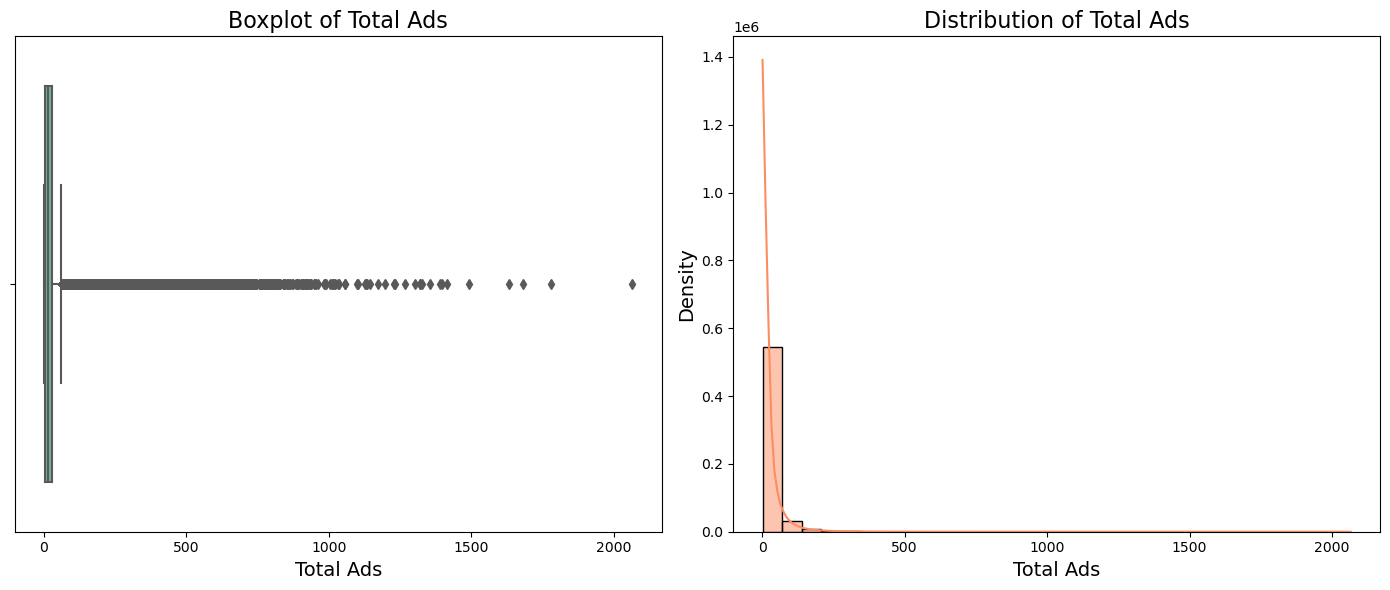

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot on the left
sns.boxplot(ax=axes[0], x=data['total ads'], color='#66c2a5')
axes[0].set_title('Boxplot of Total Ads', fontsize=16)
axes[0].set_xlabel('Total Ads', fontsize=14)

# Distribution plot on the right
sns.histplot(data['total ads'], kde=True, ax=axes[1], color='#fc8d62', bins=30)
axes[1].set_title('Distribution of Total Ads', fontsize=16)
axes[1].set_xlabel('Total Ads', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [12]:
data[data['converted']==0]['total ads'].mean()

23.291495277867906

In [13]:
data[data['converted']==1]['total ads'].mean()

83.88775853937884

The higher mean value of total ads shown to converted users suggests that individuals who converted were exposed to significantly more ads compared to those who did not convert.

In [14]:
q1 = data['total ads'].quantile(0.25)
q3 = data['total ads'].quantile(0.75)
iqr = q3 - q1

In [15]:
q3 + 1.5 * iqr

61.5

In [16]:
data[data['total ads']>61.5].shape

(52057, 6)

We observed that the upper limit of the interquartile range (IQR) for total ads was calculated to be 61.5. However, dropping all rows above this threshold would result in a significant loss of data, which may compromise the integrity of our analysis. Therefore, I opted to set a cap at 500 for the total ads, allowing us to retain more data while still addressing the presence of outliers.

In [17]:
data[data['total ads']>500].shape

(585, 6)

In [18]:
data = data[data['total ads']<500]

In [19]:
ads = data[data['test group'] == 'ad']
psa = data[data['test group'] == 'psa']

### Exploratory Data Analysis
#### Looking most ads day and conversion rates related to each day

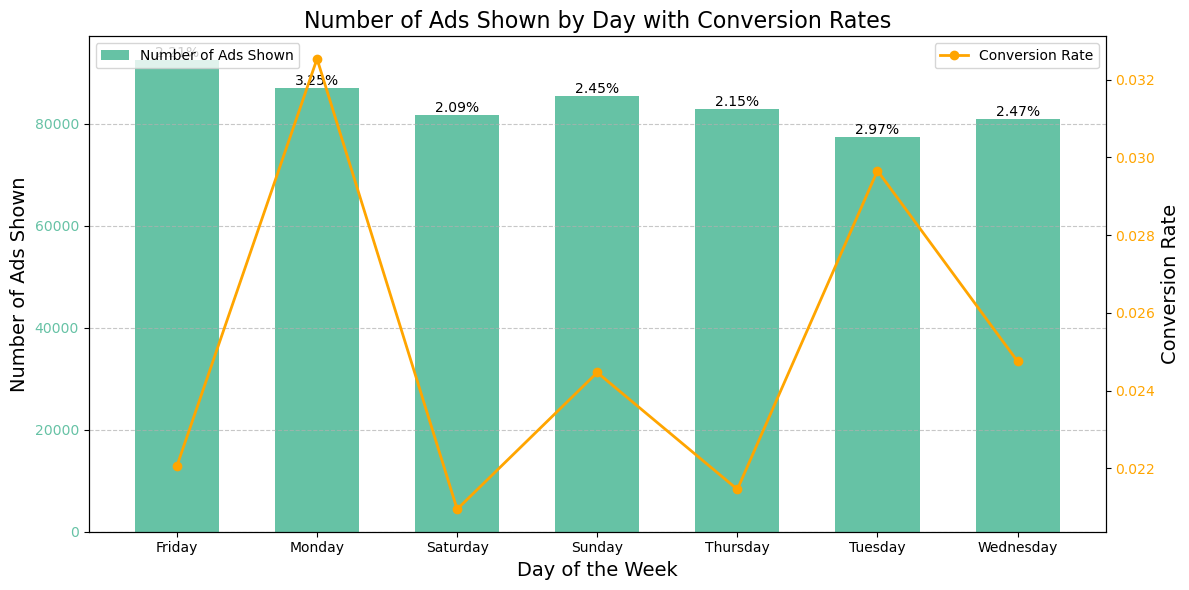

In [20]:
day_counts = data['most ads day'].value_counts().sort_index()  # Sort by day for better readability

# Calculate conversion rates for each day
conversion_rates = data.groupby('most ads day')['converted'].mean().sort_index()  # Calculate mean for conversion rates

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for the number of ads shown
bars = ax1.bar(day_counts.index, day_counts.values, width=0.6, color='#66c2a5', label='Number of Ads Shown')

# Adding titles and labels for the first y-axis
ax1.set_title('Number of Ads Shown by Day with Conversion Rates', fontsize=16)
ax1.set_xlabel('Day of the Week', fontsize=14)
ax1.set_ylabel('Number of Ads Shown', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#66c2a5')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a second y-axis for the conversion rates
ax2 = ax1.twinx()
ax2.plot(conversion_rates.index, conversion_rates.values, color='orange', marker='o', label='Conversion Rate', linewidth=2)
ax2.set_ylabel('Conversion Rate', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

# Annotate bars with conversion rates
for bar, conversion_rate in zip(bars, conversion_rates):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{conversion_rate:.2%}', ha='center', va='bottom')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

Although the number of ads shown on Friday is the highest, Monday has the highest conversion rate. However, we cannot definitively claim that Monday's conversion rate is better than other days without applying hypothesis testing. We will compare Monday's conversion rate with those of other days to determine if the observed differences are statistically significant. If we find that Monday's conversion rate is significantly higher, it could be beneficial for our marketing strategy, as it may inform decisions about when to run ads for maximum effectiveness.

#### Looking at most ads hour and conversion rates in each hours

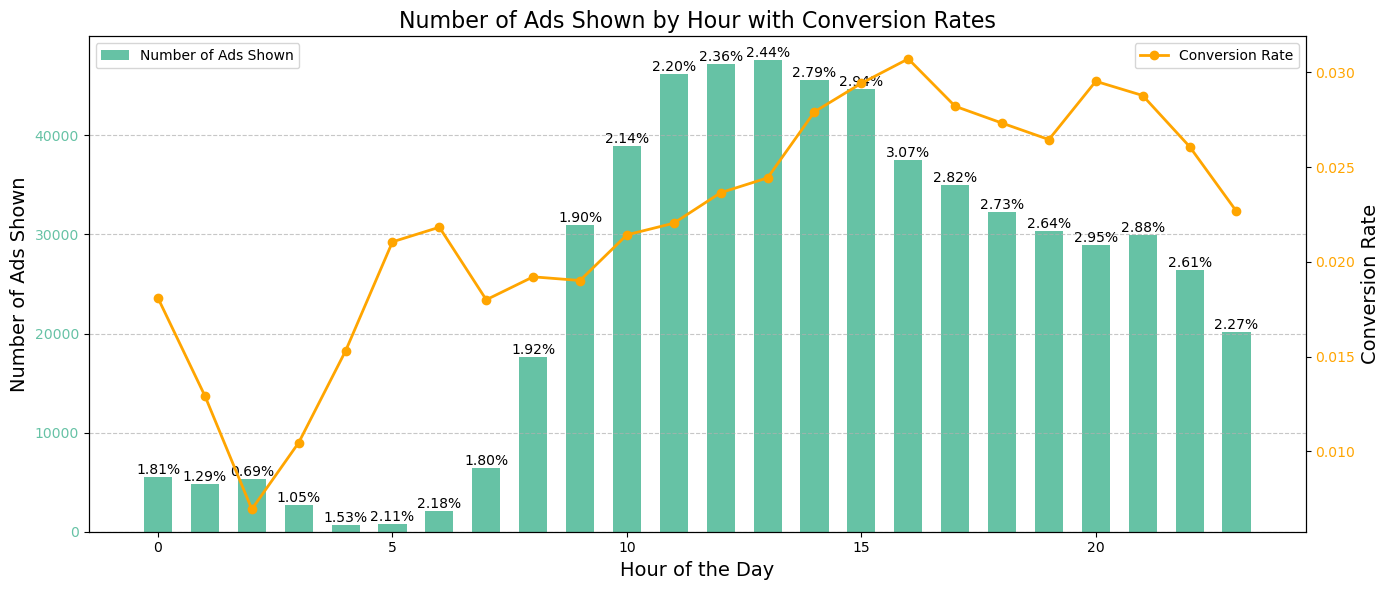

In [21]:
hour_counts = data['most ads hour'].value_counts().sort_index()  # Sort by hour for better readability

# Calculate conversion rates for each hour
conversion_rates = data.groupby('most ads hour')['converted'].mean().sort_index()  # Calculate mean for conversion rates

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for the number of ads shown
bars = ax1.bar(hour_counts.index, hour_counts.values, width=0.6, color='#66c2a5', label='Number of Ads Shown')

# Adding titles and labels for the first y-axis
ax1.set_title('Number of Ads Shown by Hour with Conversion Rates', fontsize=16)
ax1.set_xlabel('Hour of the Day', fontsize=14)
ax1.set_ylabel('Number of Ads Shown', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#66c2a5')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Create a second y-axis for the conversion rates
ax2 = ax1.twinx()
ax2.plot(conversion_rates.index, conversion_rates.values, color='orange', marker='o', label='Conversion Rate', linewidth=2)
ax2.set_ylabel('Conversion Rate', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

# Annotate bars with conversion rates
for bar, conversion_rate in zip(bars, conversion_rates):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{conversion_rate:.2%}', ha='center', va='bottom')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

Similarly, we observe that the majority of ads were shown between 10 AM and 2 PM, while the peak conversion rates occurred between 3 PM and 5 PM, and again from 8 PM to 10 PM, despite fewer ads being displayed during these times. This suggests important insights into our customers' behavior. However, we cannot make definitive claims based on these observations alone; we will need to conduct hypothesis testing to validate these findings.

#### Looking at conversions in each group ads and psa (Conversion Rates)

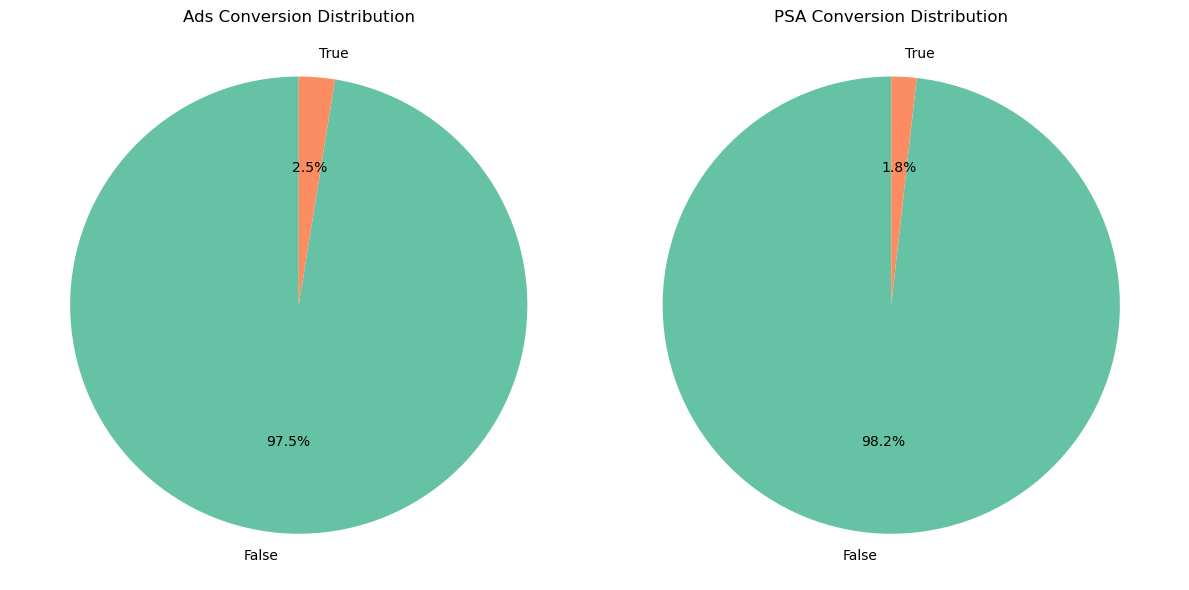

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for ads
axs[0].pie(ads['converted'].value_counts().values, 
           labels=ads['converted'].value_counts().index,
           autopct='%1.1f%%', 
           startangle=90, 
           colors=['#66c2a5', '#fc8d62'])
axs[0].set_title('Ads Conversion Distribution')

# Pie chart for psa
axs[1].pie(psa['converted'].value_counts().values, 
           labels=psa['converted'].value_counts().index,
           autopct='%1.1f%%', 
           startangle=90, 
           colors=['#66c2a5', '#fc8d62'])
axs[1].set_title('PSA Conversion Distribution')

# Equal aspect ratio ensures that pie charts are circular
for ax in axs:
    ax.axis('equal')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

From here also, we can observe that the ads conversion rate is higher than that of the PSA (control group). However, we need to confirm this through statistical testing, which is the essence of A/B testing. If we find significant evidence to support this observation, it will be useful for making informed decisions regarding our advertising strategy."

#### Finding Conversion Rate for Each Group
##### Conversion Rate Formula (proportion)

The conversion rate can be calculated using the following formula:

$$
\text{Conversion Rate} = \frac{\text{Number of Conversions}}{\text{Total Users}}
$$


In [23]:
ads_conversion = ads['converted'].mean()
psa_conversion = psa['converted'].mean()

### Power Analysis

Power analysis is used to determine the minimum required sample size for each group in a study. It helps ensure that the study has adequate power (typically 0.8) to detect an effect if one exists, minimizing the risk of Type II errors. By considering the significance level (α), effect size, and desired power, researchers can design studies that are both efficient and reliable, ensuring valid conclusions from the data.


In [24]:
# Define parameters
alpha = 0.05  # significance level
power = 0.8   # desired power
effect_size = (ads_conversion - psa_conversion) / ((ads_conversion + psa_conversion) / 2)

# Calculate required sample size
analysis = NormalIndPower()
required_n = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

print(f'Required sample size per group: {required_n}')

Required sample size per group: 126.28666884148532


### Hypotheses Definition

- **Null Hypothesis (H₀)**: There is no significant difference in conversion rates between the ad campaign (A) and the control campaign (B). This means that any observed differences in conversion rates are due to random chance.

- **Alternative Hypothesis (H₁)**: There is a significant difference in conversion rates between the ad campaign (A) and the control campaign (B). This indicates that the variations in conversion rates are likely due to the effect of the ads.


### Statistical Tests: To check the success of ads (Ads vs PSA)

In this analysis, we can apply the Chi-square test, as our data is binary. Given the imbalanced nature of the data, we will also utilize the proportion Z-test to assess the conversion rates, allowing for a comparison of conversion rates between the ad and PSA groups.


#### Using Proportion Z-test

In [25]:
# Total number of users in each group
n_ads = ads.shape[0]
n_psa = psa.shape[0]

# Actual number of conversions
ads_converted = ads['converted'].sum()
psa_converted = psa['converted'].sum()

# Perform the z-test
count = [ads_converted, psa_converted]  # conversion counts for both groups
nobs = [n_ads, n_psa]  # number of users in both groups
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')  # 'larger' for one-tailed test

# Display results
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Check p-value against significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")


Z-statistic: 7.3106184879190685
P-value: 1.3295777233392764e-13
Reject the null hypothesis: There is a significant difference in conversion rates.


#### Using Chi2 test

In [26]:
pd.crosstab(data['test group'], data['converted'])

converted,False,True
test group,,
ad,549684,14323
psa,23087,418


In [27]:
import scipy.stats as stats

# Create the contingency table
contingency_table = pd.crosstab(data['test group'], data['converted'])

# Perform the chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print(f"Chi2 Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: {expected}")

# Check p-value against significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in conversion rates.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates.")


Chi2 Statistic: 53.13442191948595
P-Value: 3.114859290277625e-13
Degrees of Freedom: 1
Expected Frequencies: [[549855.75340929  14151.24659071]
 [ 22915.24659071    589.75340929]]
Reject the null hypothesis: There is a significant difference in conversion rates.


In [28]:
# Assuming you have already calculated the conversion rates for ad and PSA groups
ads_conversion = data[data['test group'] == 'ad']['converted'].mean()  # Conversion rate for ads
psa_conversion = data[data['test group'] == 'psa']['converted'].mean()  # Conversion rate for PSA

# Calculate the lift
lift = (ads_conversion - psa_conversion) / psa_conversion

# Print the results
print(f"Conversion rate for Ads group: {ads_conversion:.4f}")
print(f"Conversion rate for PSA group: {psa_conversion:.4f}")
print(f"Lift due to Ads: {lift:.4%}")


Conversion rate for Ads group: 0.0254
Conversion rate for PSA group: 0.0178
Lift due to Ads: 42.8017%


### Ad vs. PSA Effectiveness: Daily Performance Analysis

In [29]:
days = data['most ads day'].unique()

# Iterate through each day
for day in days:
    day_data = data[data['most ads day'] == day]

    ads = day_data[day_data['test group'] == 'ad']
    psa = day_data[day_data['test group'] == 'psa']

    # Conversion rates
    p_ads = ads['converted'].mean()
    p_psa = psa['converted'].mean()

    # Total number of users in each group
    n_ads = ads.shape[0]
    n_psa = psa.shape[0]

    # Actual number of conversions
    conversions_ads = int(p_ads * n_ads)
    conversions_psa = int(p_psa * n_psa)

    # Perform the z-test
    count = [conversions_ads, conversions_psa]  # conversion counts for both groups
    nobs = [n_ads, n_psa]  # number of users in both groups
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')  # 'larger' for one-tailed test

    # Display results
    print(f"Day: {day}")
    print(f"Z-statistic: {z_stat}")
    print(f"P-value: {p_value}")

    # Add an if-else condition to check the significance level
    if p_value < 0.05:
        print(f"The result is significant for {day}. We reject the null hypothesis.")
    else:
        print(f"The result is not significant for {day}. We fail to reject the null hypothesis.")
    print("-" * 50)

Day: Monday
Z-statistic: 3.3885244200489275
P-value: 0.00035134885704796555
The result is significant for Monday. We reject the null hypothesis.
--------------------------------------------------
Day: Tuesday
Z-statistic: 4.924782376221665
P-value: 4.2227145665950337e-07
The result is significant for Tuesday. We reject the null hypothesis.
--------------------------------------------------
Day: Friday
Z-statistic: 2.4615721044365886
P-value: 0.006916479479126008
The result is significant for Friday. We reject the null hypothesis.
--------------------------------------------------
Day: Wednesday
Z-statistic: 3.484010061698557
P-value: 0.0002469804589011389
The result is significant for Wednesday. We reject the null hypothesis.
--------------------------------------------------
Day: Sunday
Z-statistic: 1.4079892670543168
P-value: 0.07956712407620792
The result is not significant for Sunday. We fail to reject the null hypothesis.
--------------------------------------------------
Day: Sat

We failed to reject the null hypothesis for Sunday and Thursday, meaning that the higher ads conversion rate on these days might be due to random variations rather than a significant effect of the ads. This suggests that we should further investigate the ads shown on Sunday and Thursday, along with the timings, to identify potential improvements and increase the conversion rate.

### Identifying (claiming) Peak Conversion Days and Hours

Previously, we observed a higher conversion rate on Mondays. To validate this trend and draw more definitive conclusions, let's conduct a series of A/B tests to determine if Mondays truly outperform other days of the week.

In [30]:
days_of_week = data['most ads day'].unique()

alpha = 0.05  # Original significance level
bonferroni_alpha = alpha / (len(days_of_week) - 1)  # Bonferroni correction for multiple comparisons

# Loop through each day, comparing it with Monday
for day in days_of_week:
    if day == 'Monday':
        continue  # Skip Monday as we are comparing other days with Monday
    
    # Data for Monday
    monday = data[data['most ads day'] == 'Monday']
    monday_ads = monday[monday['test group'] == 'ad']
    monday_psa = monday[monday['test group'] == 'psa']

    # Data for the current day in the loop
    current_day = data[data['most ads day'] == day]
    current_day_ads = current_day[current_day['test group'] == 'ad']
    current_day_psa = current_day[current_day['test group'] == 'psa']

    # Z-test for 'ad' group
    n_monday_ads = monday_ads.shape[0]
    n_current_day_ads = current_day_ads.shape[0]
    count_ads = [monday_ads['converted'].sum(), current_day_ads['converted'].sum()]
    nobs_ads = [n_monday_ads, n_current_day_ads]
    z_stat_ads, p_z_ads = proportions_ztest(count_ads, nobs_ads, alternative='larger')  # One-tailed test

    # Z-test for 'psa' group
    n_monday_psa = monday_psa.shape[0]
    n_current_day_psa = current_day_psa.shape[0]
    count_psa = [monday_psa['converted'].sum(), current_day_psa['converted'].sum()]
    nobs_psa = [n_monday_psa, n_current_day_psa]
    z_stat_psa, p_z_psa = proportions_ztest(count_psa, nobs_psa, alternative='larger')  # One-tailed test

    # Print Z-test results for the current day
    print(f"\nComparison between Monday and {day}:")
    print(f"Ad Group - Z-Statistic: {z_stat_ads}, P-value: {p_z_ads}")
    print(f"PSA Group - Z-Statistic: {z_stat_psa}, P-value: {p_z_psa}")

    # Interpretation of the Z-test results using Bonferroni alpha
    if p_z_ads < bonferroni_alpha:
        print(f"Ad Group: Monday has a significantly higher conversion rate than {day} (p < {bonferroni_alpha}).")
    else:
        print(f"Ad Group: No significant difference in conversion rates between Monday and {day} (p >= {bonferroni_alpha}).")

    if p_z_psa < bonferroni_alpha:
        print(f"PSA Group: Monday has a significantly higher conversion rate than {day} (p < {bonferroni_alpha}).")
    else:
        print(f"PSA Group: No significant difference in conversion rates between Monday and {day} (p >= {bonferroni_alpha}).")


Comparison between Monday and Tuesday:
Ad Group - Z-Statistic: 3.061121501025636, P-value: 0.0011025479647213971
PSA Group - Z-Statistic: 2.3778977803309203, P-value: 0.00870582594585066
Ad Group: Monday has a significantly higher conversion rate than Tuesday (p < 0.008333333333333333).
PSA Group: No significant difference in conversion rates between Monday and Tuesday (p >= 0.008333333333333333).

Comparison between Monday and Friday:
Ad Group - Z-Statistic: 13.507083413303796, P-value: 7.101896773800209e-42
PSA Group - Z-Statistic: 1.9418216890131614, P-value: 0.026079345133360847
Ad Group: Monday has a significantly higher conversion rate than Friday (p < 0.008333333333333333).
PSA Group: No significant difference in conversion rates between Monday and Friday (p >= 0.008333333333333333).

Comparison between Monday and Wednesday:
Ad Group - Z-Statistic: 9.278182837199289, P-value: 8.619674597164862e-21
PSA Group - Z-Statistic: 2.073384492776344, P-value: 0.019068255479053477
Ad Grou

In [31]:
days_of_week = data['most ads day'].unique()

alpha = 0.05 # Since we are comparing Monday with 6 other days
bonferroni_alpha = alpha / (len(days_of_week) - 1)

# Loop through each day, comparing it with Monday
for day in days_of_week:
    if day == 'Monday':
        continue  # Skip Monday as we are comparing other days with Monday
    
    # Data for Monday
    monday = data[data['most ads day'] == 'Monday']
    monday_ads = monday[monday['test group'] == 'ad']
    monday_psa = monday[monday['test group'] == 'psa']

    # Data for the current day in the loop
    current_day = data[data['most ads day'] == day]
    current_day_ads = current_day[current_day['test group'] == 'ad']
    current_day_psa = current_day[current_day['test group'] == 'psa']

    # Contingency table for 'ad' group comparison (Monday vs. current day)
    ad_contingency_table = [
        [monday_ads['converted'].sum(), monday_ads['converted'].count() - monday_ads['converted'].sum()],
        [current_day_ads['converted'].sum(), current_day_ads['converted'].count() - current_day_ads['converted'].sum()]
    ]
    
    # Contingency table for 'psa' group comparison (Monday vs. current day)
    psa_contingency_table = [
        [monday_psa['converted'].sum(), monday_psa['converted'].count() - monday_psa['converted'].sum()],
        [current_day_psa['converted'].sum(), current_day_psa['converted'].count() - current_day_psa['converted'].sum()]
    ]

    # Chi-square test for 'ad' group
    chi2_ad, p_ad, dof_ad, expected_ad = chi2_contingency(ad_contingency_table)
    
    # Chi-square test for 'psa' group
    chi2_psa, p_psa, dof_psa, expected_psa = chi2_contingency(psa_contingency_table)

    # Print results for the current day
    print(f"\nComparison between Monday and {day}:")
    print(f"Ad Group - Chi2: {chi2_ad}, P-value: {p_ad}")
    print(f"PSA Group - Chi2: {chi2_psa}, P-value: {p_psa}")



    # Interpretation of the results
    if p_ad < bonferroni_alpha:
        print(f"Ad Group: Significant difference after Bonferroni correction (p < {bonferroni_alpha:.5f}).")
    else:
        print(f"Ad Group: No significant difference after Bonferroni correction (p >= {bonferroni_alpha:.5f}).")

    if p_psa < bonferroni_alpha:
        print(f"PSA Group: There is a significant difference in conversion rates between Monday and {day} (p < {bonferroni_alpha:.5f}).")
    else:
        print(f"PSA Group: No significant difference in conversion rates between Monday and {day} (p >= {bonferroni_alpha:.5f}).")


Comparison between Monday and Tuesday:
Ad Group - Chi2: 9.282579417428666, P-value: 0.0023134342650943515
PSA Group - Chi2: 5.224523767932712, P-value: 0.022270543926953254
Ad Group: Significant difference after Bonferroni correction (p < 0.00833).
PSA Group: No significant difference in conversion rates between Monday and Tuesday (p >= 0.00833).

Comparison between Monday and Friday:
Ad Group - Chi2: 182.0429535484546, P-value: 1.7352987928497456e-41
PSA Group - Chi2: 3.4473671715535046, P-value: 0.0633526100359095
Ad Group: Significant difference after Bonferroni correction (p < 0.00833).
PSA Group: No significant difference in conversion rates between Monday and Friday (p >= 0.00833).

Comparison between Monday and Wednesday:
Ad Group - Chi2: 85.8098369278731, P-value: 1.9809826631795775e-20
PSA Group - Chi2: 3.9448192572416967, P-value: 0.047015904156621026
Ad Group: Significant difference after Bonferroni correction (p < 0.00833).
PSA Group: No significant difference in conversio

Based on the p-values, we find a statistically significant difference in conversion rates for ads displayed on Monday compared to other days of the week. However, no significant difference was observed for PSA conversions. These results suggest that ads on Monday are more effective in driving conversions than those on other days. Consequently, we recommend increasing ad frequency on Mondays to capitalize on this observed performance advantage.

Similarly, we observe that the majority of ads were shown between 10 AM and 2 PM, while the peak conversion rates occurred between 3 PM and 5 PM, and again from 8 PM to 10 PM, despite fewer ads being displayed during these times. This suggests important insights into our customers' behavior. However, we cannot make definitive claims based on these observations alone; we will need to conduct hypothesis testing to validate these findings.

In [32]:
# Define key time slots: 3 PM to 5 PM (15:00 to 17:00) and 8 PM to 10 PM (20:00 to 22:00)
key_time_slots = [(15, 17), (20, 22)]

# Initialize a list to store results
results = []

for start, end in key_time_slots:
    # Create two groups: the key time slot vs. all other hours
    key_time_data = data[(data['most ads hour'] >= start) & (data['most ads hour'] <= end)]
    other_hours_data = data[(data['most ads hour'] < start) | (data['most ads hour'] > end)]
    
    # Calculate the number of users and conversions for each group
    n_key = key_time_data.shape[0]
    n_other = other_hours_data.shape[0]
    conversions_key = key_time_data['converted'].sum()
    conversions_other = other_hours_data['converted'].sum()
    
    # Perform the proportion z-test (one-tailed test)
    count = [conversions_key, conversions_other]
    nobs = [n_key, n_other]
    z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')  # 'larger' for one-tailed test
    
    # Store the results
    results.append({
        'Key Time Slot': f"{start}:00 - {end}:00",
        'Conversion Rate (Key Time)': conversions_key / n_key,
        'Conversion Rate (Other Hours)': conversions_other / n_other,
        'Z-Statistic': z_stat,
        'P-Value': p_value
    })

# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Interpretation of the result based on z-statistic and p-value
for result in results:
    if result['P-Value'] < 0.05:
        if result['Z-Statistic'] > 0:
            print(f"The time slot {result['Key Time Slot']} has a significantly higher conversion rate.")
        else:
            print(f"The time slot {result['Key Time Slot']} has a significantly lower conversion rate.")
    else:
        print(f"The time slot {result['Key Time Slot']} does not show a significant difference in conversion rate.")

   Key Time Slot  Conversion Rate (Key Time)  Conversion Rate (Other Hours)  \
0  15:00 - 17:00                    0.029469                       0.024000   
1  20:00 - 22:00                    0.028192                       0.024564   

   Z-Statistic       P-Value  
0    10.708396  4.647945e-27  
1     6.263292  1.884673e-10  
The time slot 15:00 - 17:00 has a significantly higher conversion rate.
The time slot 20:00 - 22:00 has a significantly higher conversion rate.


In [33]:
# Define key time slots: 3 PM to 5 PM (15:00 to 17:00) and 8 PM to 10 PM (20:00 to 22:00)
key_time_slots = [(15, 17), (20, 22)]

# Initialize a list to store results
chi2_results = []

for start, end in key_time_slots:
    # Create two groups: the key time slot vs. all other hours
    key_time_data = data[(data['most ads hour'] >= start) & (data['most ads hour'] <= end)]
    other_hours_data = data[(data['most ads hour'] < start) | (data['most ads hour'] > end)]
    
    # Create contingency table
    key_converted = key_time_data['converted'].sum()  # Conversions in key time
    key_not_converted = key_time_data.shape[0] - key_converted  # Non-conversions in key time
    other_converted = other_hours_data['converted'].sum()  # Conversions in other hours
    other_not_converted = other_hours_data.shape[0] - other_converted  # Non-conversions in other hours
    
    contingency_table = [[key_converted, key_not_converted], [other_converted, other_not_converted]]
    
    # Perform Chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results
    chi2_results.append({
        'Key Time Slot': f"{start}:00 - {end}:00",
        'Conversion Rate (Key Time)': key_converted / key_time_data.shape[0],
        'Conversion Rate (Other Hours)': other_converted / other_hours_data.shape[0],
        'Chi-Square Statistic': chi2_stat,
        'P-Value': p_value
    })

# Convert results to a DataFrame for easy visualization
chi2_results_df = pd.DataFrame(chi2_results)

# Display the results
print(chi2_results_df)

# Interpretation of the result based on chi2-statistic and p-value
for result in chi2_results:
    if result['P-Value'] < 0.05:
        print(f"The time slot {result['Key Time Slot']} shows a significant difference in conversion rates.")
    else:
        print(f"The time slot {result['Key Time Slot']} does not show a significant difference in conversion rates.")

   Key Time Slot  Conversion Rate (Key Time)  Conversion Rate (Other Hours)  \
0  15:00 - 17:00                    0.029469                       0.024000   
1  20:00 - 22:00                    0.028192                       0.024564   

   Chi-Square Statistic       P-Value  
0            114.446269  1.040477e-26  
1             39.080638  4.066571e-10  
The time slot 15:00 - 17:00 shows a significant difference in conversion rates.
The time slot 20:00 - 22:00 shows a significant difference in conversion rates.


We do not necessarily need to compare every individual time slot with all other slots. Instead, we can analyze the relationship between the converted column (indicating whether a conversion occurred) and the hour column (representing different time slots).

By performing a Chi-square test of independence on these two categorical variables, we can determine if there is a significant association between the hour of the day and the conversion rate. If the test shows a significant dependency, it would indicate that the time at which the ads are displayed affects the conversion rate. Therefore, we can confidently state that the observed patterns in our analysis, such as higher conversion rates during specific hours, are supported by statistical evidence.

We will utilize this concept to investigate the relationship between the combination of day and hour with respect to conversion rates. By analyzing the performance of different day-hour combinations, we can identify which specific combinations yield the highest conversion rates for our marketing campaign. This analysis will enable us to optimize our advertising strategy by focusing on the most effective time slots for each day, ultimately enhancing our campaign's performance.

In [34]:
data['day and hour'] = data['most ads day'].astype(str) + '_' + data['most ads hour'].astype(str)

In [35]:
# Create a contingency table
contingency_table = pd.crosstab(data['day and hour'], data['converted'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Perform Chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print(f"\nChi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Check for significant relation
alpha = 0.05
if p_value < alpha:
    print("There is a significant relationship between 'day and hour' and conversion rates.")
else:
    print("There is no significant relationship between 'day and hour' and conversion rates.")

Contingency Table:
converted     False  True 
day and hour              
Friday_0        824     16
Friday_1        682      7
Friday_10      5438    129
Friday_11      7140    128
Friday_12      7166    141
...             ...    ...
Wednesday_5     142      1
Wednesday_6     360      5
Wednesday_7     845      9
Wednesday_8    2311     37
Wednesday_9    4696     79

[168 rows x 2 columns]

Chi-squared Statistic: 1249.185388701616
P-value: 6.383722997390936e-165
There is a significant relationship between 'day and hour' and conversion rates.


So we found the relation between day and hour combination, now we are going to see the peaks in conversion rates for day and hour combination and find the best combination to show ads as compared to other combination to get maximum conversion rates.

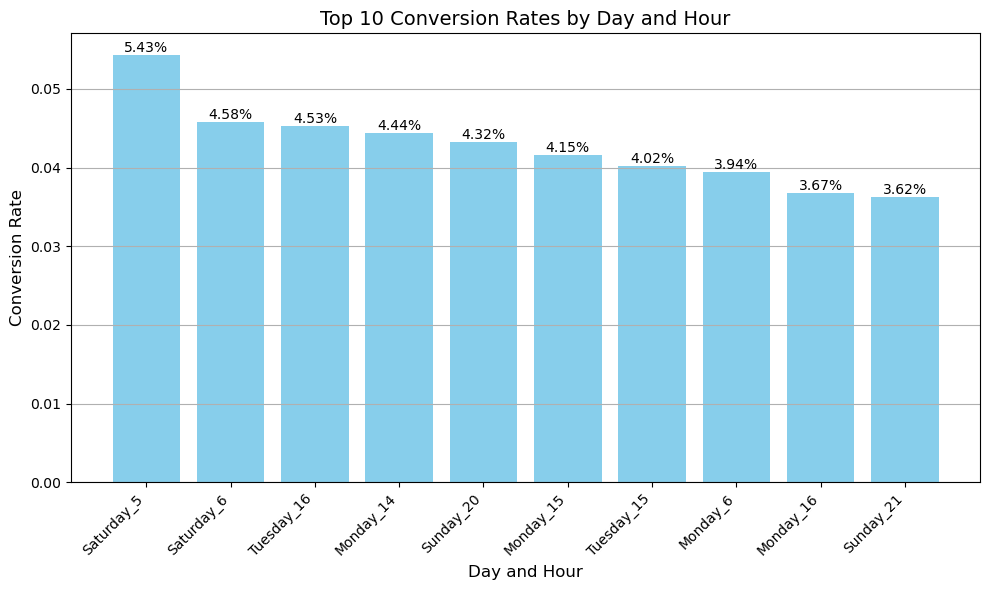

In [36]:
# Group by 'day and hour' and calculate the mean conversion rates
top_10 = data.groupby('day and hour')['converted'].mean().sort_values(ascending=False)[:10]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(x=top_10.index, height=top_10.values, color='skyblue')

# Add conversion rates on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2%}", ha='center', va='bottom', fontsize=10)

# Add labels and title
plt.xlabel('Day and Hour', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.title('Top 10 Conversion Rates by Day and Hour', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

From the analysis, we observe that the peak conversion rates occur on Saturday at 5 AM and 6 AM. This trend suggests that users are likely more active during these early hours, possibly due to a later start to their weekend following a Friday night out.

### Conclusion

In this project, we conducted a thorough analysis of our advertising campaign, which yielded valuable insights into the performance of ads compared to PSAs. Our findings indicate that ads significantly outperformed PSAs overall, particularly on Mondays, where we observed the highest conversion rates. And there is a lift of 42.80% in conversion rates for ads group rather in psa group. So our marketing campaign was successful.

We identified specific peak times for conversions, notably between 3 PM to 5 PM and 8 PM to 10 PM on weekdays, as well as early Saturday mornings at 5 AM and 6 AM. These peaks suggest that user engagement is highest during these periods, indicating optimal times for ad placements.

Additionally, our analysis revealed that ads did not perform well on Thursdays, as indicated by a high p-value in our statistical tests. This insight highlights the importance of continuously assessing ad performance across different days to refine our marketing strategy.

Moving forward, we recommend focusing our marketing efforts on the following strategies: 

1. **Targeted Timing**: Schedule ad placements during the identified peak conversion periods to maximize user engagement and conversion rates. 

2. **Weekend Strategies**: Increase ad visibility on Saturday mornings to leverage user activity during these times when users are likely waking up later and engaging more with their devices.

3. **Continuous Monitoring**: Implement ongoing analysis of ad performance across different days and times to make data-driven adjustments in real-time.

4. **Testing Variations**: Conduct A/B tests for different ad creatives and formats during high-conversion periods to further optimize performance.

Overall, the success of our campaign demonstrates the potential for targeted advertising strategies based on user behavior, enabling us to enhance future marketing efforts effectively.
